In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from models.EncoderDecoderIndependentMLP import Encoder, Decoder
import pyarrow.parquet as pq
from datasets.dataOps import create_datasets, create_dataloaders
from utils.utilities import load_checkpoint
from utils.metrics import IntegratedEvaluator

# Import IDs

In [2]:
table = pq.read_table("data/info_ts.parquet")
ids = table.to_pandas().index.to_list()

In [3]:
data = {}
for array in ["static_data", "before_ts", "after_ts", "target_ts", "mask_target", "cat_dicos"]:
        with open(f"data/{array}.pkl", "rb") as f:
            data[array] = pickle.load(f)

In [4]:
hyperparameters = {
# Static encoder parameters
"static_input_dim": 9,
"list_unic_cat": [len(dico.keys()) for dico in data["cat_dicos"].values()],
"embedding_dims": [150, 150, 150, 150],
"hidden_dim_static_encoder": 256,

# Dynamic encoder parameters
"dynamic_input_dim": 7,
"hidden_dim_dynamic_encoder": 384,
"first_decoder_input_dim": 11,
"gru_encoder_num_layers": 2,

# Decoder parameters
"gru_input_dim": 11,
"gru_hidden_dim": 384 + 256,  # hidden_dim_dynamic_encoder + hidden_dim_static_encoder
"stepwise_input_dim": 7,
"main_hidden_dim": 256,
"mask_hidden_dim": 256,
"output_dim": 11,
"gru_decoder_num_layers": 2,

# Training cycle parameters
"batch_size": 64,
"teacher_forcing_ratio": 0.7,
"max_norm": 1.0,
"learning_rate": 1e-4,
"num_epochs": 60,
}

In [5]:
train_dataset, val_dataset, test_dataset = create_datasets(ids=ids,
                                                               static_data=data["static_data"],
                                                               before_ts=data["before_ts"],
                                                               after_ts=data["after_ts"],
                                                               target_ts=data["target_ts"],
                                                               mask_target=data["mask_target"],
                                                               train_size=0.6,
                                                               val_size=0.2,
                                                               raw_data_folder="data/",
                                                               means_and_stds_path="data/work_data/means_and_stds.pkl",
                                                               )
    
train_loader, val_loader, test_loader = create_dataloaders(train_dataset,
                                                            val_dataset,
                                                            test_dataset,
                                                            batch_size=hyperparameters["batch_size"])


          Train_DS = 120051 obs
          Val_DS = 40017 obs
          Test_DS = 40018 obs
          


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)

encoder = Encoder(
    static_input_dim=hyperparameters["static_input_dim"],
    static_hidden_dim=hyperparameters["hidden_dim_static_encoder"],
    list_unic_cat=hyperparameters["list_unic_cat"],
    embedding_dims=hyperparameters["embedding_dims"],
    dynamic_input_dim=hyperparameters["dynamic_input_dim"],
    dynamic_hidden_dim=hyperparameters["hidden_dim_dynamic_encoder"],
    first_decoder_input_dim=hyperparameters["first_decoder_input_dim"],
    gru_num_layers=hyperparameters["gru_encoder_num_layers"]
    ).to(device)

decoder = Decoder(
    gru_input_dim=hyperparameters["gru_input_dim"],
    gru_hidden_dim=hyperparameters["gru_hidden_dim"],
    stepwise_input_dim=hyperparameters["stepwise_input_dim"],
    main_hidden_dim=hyperparameters["main_hidden_dim"],
    output_dim=hyperparameters["output_dim"],
    num_layers=hyperparameters["gru_decoder_num_layers"]
    ).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)


Using device: cuda


In [7]:
checkpoint = torch.load("checkpoints/03_entire_non_physical_multiMLP_60_eps/best_model.pth")
load_checkpoint(checkpoint,
                encoder,
                decoder,
                optimizer)

=== Loading checkpoint ===


In [8]:
# Import Means and Standard Deviations
with open("data/work_data/means_and_stds.pkl", "rb") as f:
    means_and_stds = pickle.load(f)


In [9]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    batch_hat_target = []
    batch_hat_mask = []
    batch_target = []
    batch_mask = []
    ids = []
    for batch in test_loader:
        ids.append(batch["id"])
        static_data_cat = batch["static_data_cat"].to(device)
        static_data_num = batch["static_data_num"].to(device)
        before_ts = batch["before_ts"].to(device)
        after_ts = batch["after_ts"].to(device)
        target_ts = batch["target_ts"].to(device)
        mask_target = batch["mask_target"].to(device)

        latent, x_t = encoder(static_data_num, static_data_cat, before_ts)
        h_t = latent
        generated_ts = [] 
        for t in range(after_ts.shape[1]):
            output, h_t, h_output = decoder(x_t.unsqueeze(1), h_t, after_ts[:, t, :])
            x_t = output
            generated_ts.append(output)

        batch_hat_target.append((torch.stack(generated_ts, dim=1).to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
        batch_target.append((target_ts.to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
        # batch_hat_target.append(torch.stack(generated_ts, dim=1))
        # batch_target.append(target_ts)
        batch_mask.append(mask_target)
    # all_ts = torch.stack(batch_ts, dim=1)
    # all_mask = torch.stack(batch_mask, dim=1)

/tmp/ipykernel_3765186/3389845642.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  batch_hat_target.append((torch.stack(generated_ts, dim=1).to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
/tmp/ipykernel_3765186/3389845642.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  batch_target.append((target_ts.to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])


In [10]:
print(batch_target[0].shape, batch_hat_target[0].shape)

torch.Size([128, 200, 11]) torch.Size([128, 200, 11])


In [11]:
print(len(batch_mask))

313


In [12]:
batch_hat_target[0][0].shape

torch.Size([200, 11])

00035394-05af-4f16-bfc9-8cd7aa3de1fd


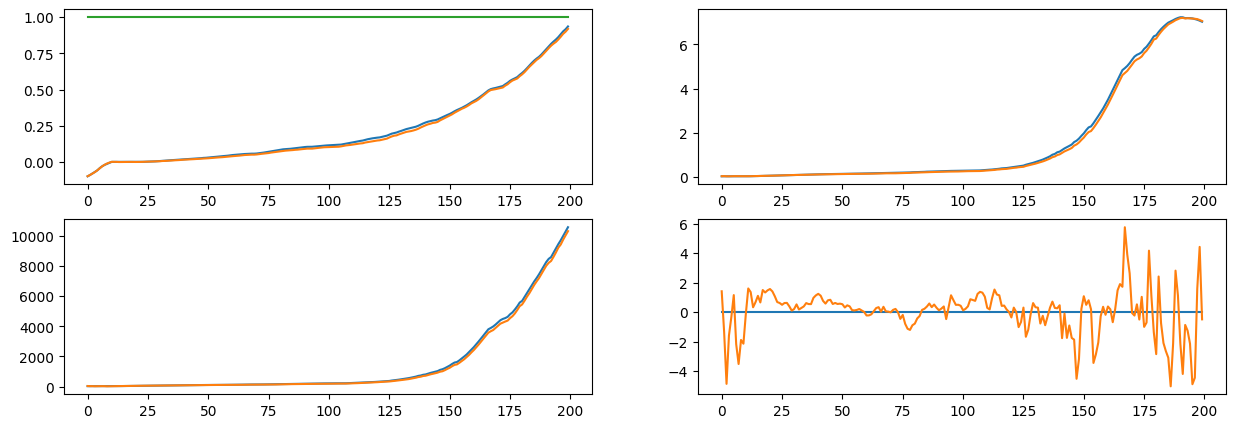

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
i = 13
print(ids[0][i])
sns.lineplot(batch_target[0][i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(batch_hat_target[0][i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(batch_mask[0][i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(batch_target[0][i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(batch_hat_target[0][i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(batch_target[0][i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(batch_hat_target[0][i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(batch_target[0][i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(batch_hat_target[0][i][:,3].to("cpu").numpy(), ax=ax[1, 1])
plt.show()

In [14]:
concat_batch_hat_target = torch.cat(batch_hat_target, dim=0).to("cpu")
concat_batch_target = torch.cat(batch_target, dim=0).to("cpu")
concat_real_mask = torch.cat(batch_mask, dim=0).to("cpu")

In [15]:
concat_real_mask.squeeze(2).numpy()

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int8)

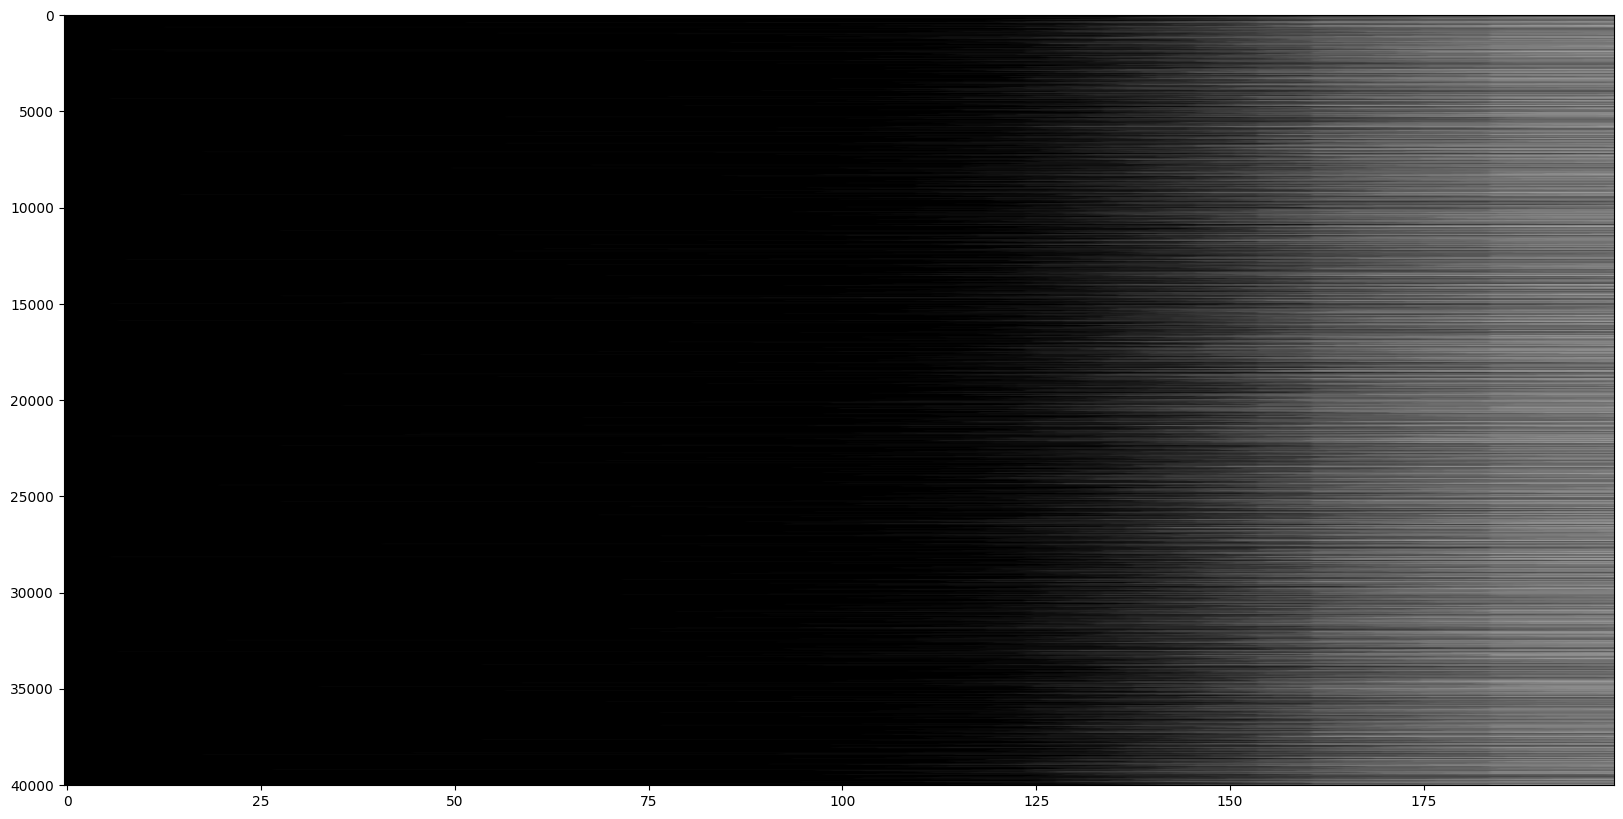

In [16]:
# Do a graphic of concat_real_mask when one line is an observation, then 1 is black, 0 is white
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(concat_real_mask.squeeze(2).numpy(), aspect="auto", cmap="binary")
plt.show()

In [17]:
# find the maximum value index

cosa = abs((concat_batch_hat_target*concat_real_mask)-(concat_batch_target*concat_real_mask))

x_flat = cosa.view(-1)

# Get index of max value
max_index = x_flat.argmax()

# Convert flat index back to multi-dimensional index
max_position = torch.unravel_index(max_index, cosa.shape)

In [18]:
x_flat[max_index].item()

20464.570261354333

In [19]:
max_position

(tensor(4471), tensor(183), tensor(2))

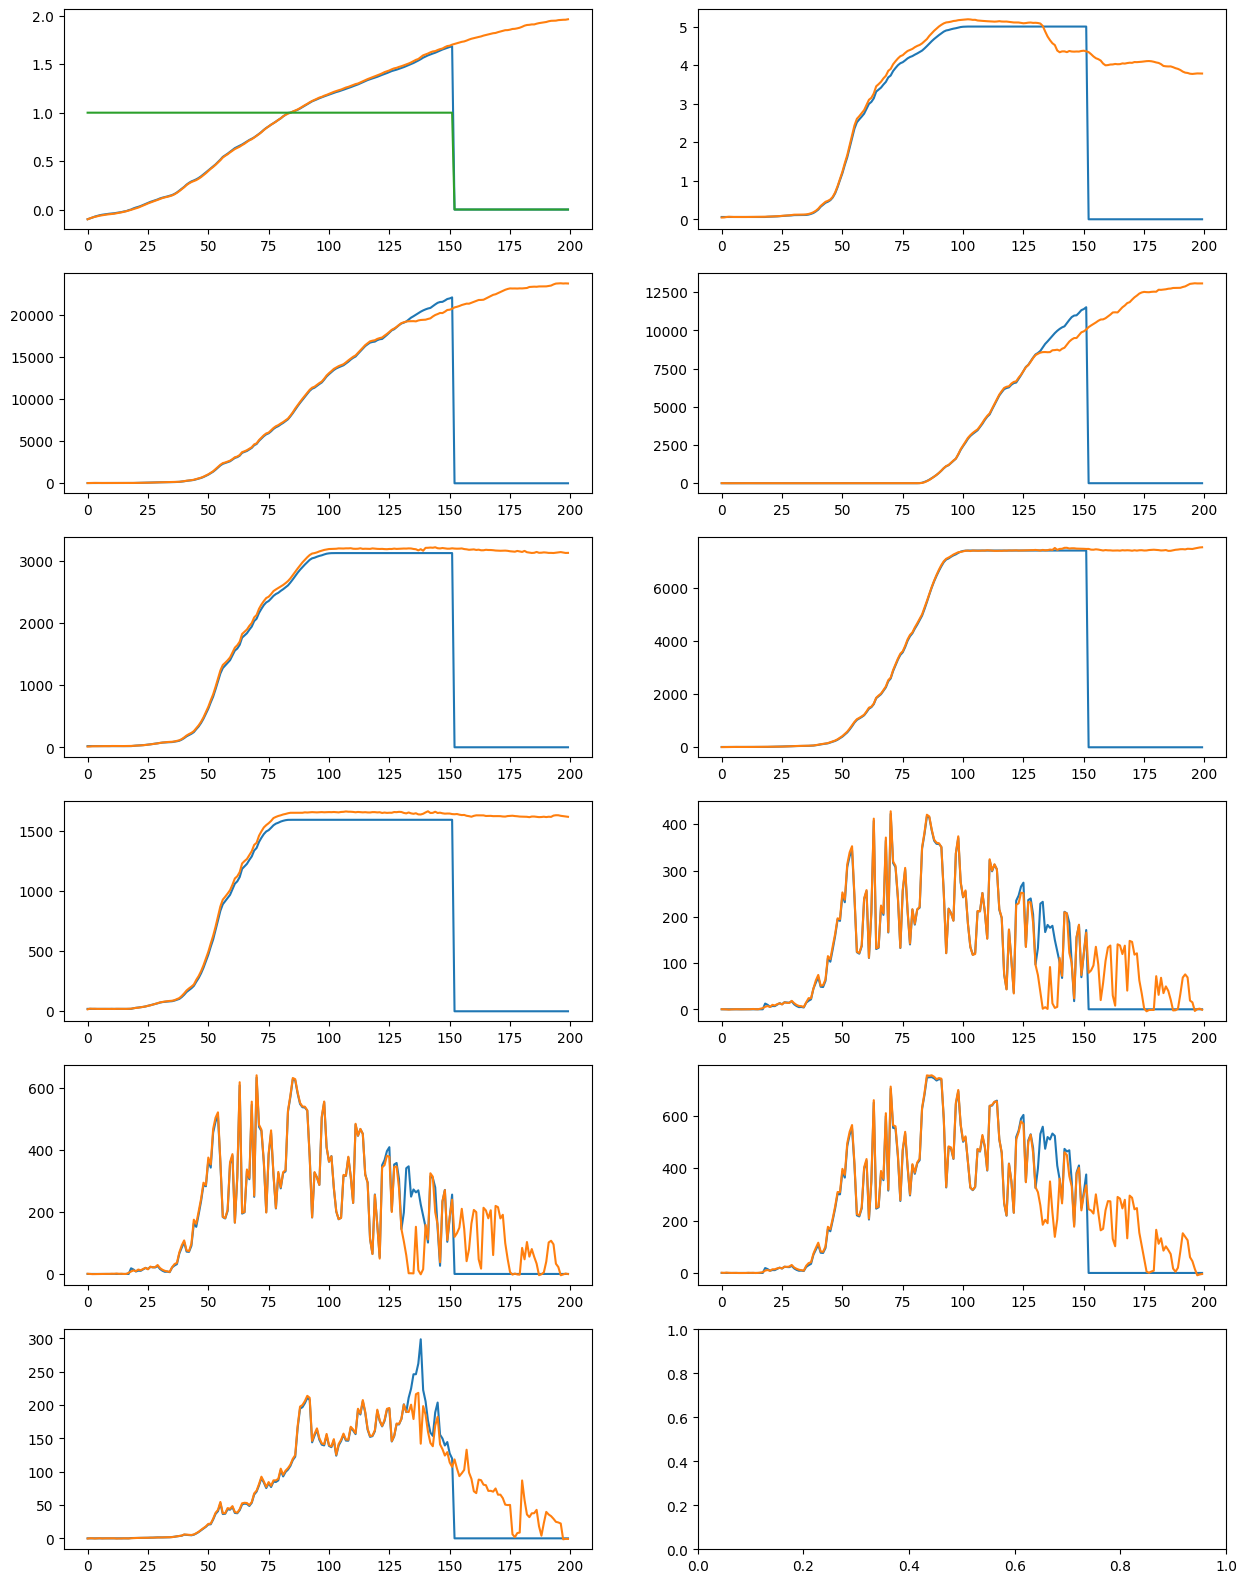

In [20]:
fig, ax = plt.subplots(6, 2, figsize=(15, 20))
i = 10
sns.lineplot(concat_batch_target[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_batch_hat_target[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_real_mask[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_batch_target[i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(concat_batch_hat_target[i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(concat_batch_target[i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(concat_batch_hat_target[i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(concat_batch_target[i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(concat_batch_hat_target[i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(concat_batch_target[i][:,4].to("cpu").numpy(), ax=ax[2, 0])
sns.lineplot(concat_batch_hat_target[i][:,4].to("cpu").numpy(), ax=ax[2, 0])
sns.lineplot(concat_batch_target[i][:,5].to("cpu").numpy(), ax=ax[2, 1])
sns.lineplot(concat_batch_hat_target[i][:,5].to("cpu").numpy(), ax=ax[2, 1])
sns.lineplot(concat_batch_target[i][:,6].to("cpu").numpy(), ax=ax[3, 0])
sns.lineplot(concat_batch_hat_target[i][:,6].to("cpu").numpy(), ax=ax[3, 0])
sns.lineplot(concat_batch_target[i][:,7].to("cpu").numpy(), ax=ax[3, 1])
sns.lineplot(concat_batch_hat_target[i][:,7].to("cpu").numpy(), ax=ax[3, 1])
sns.lineplot(concat_batch_target[i][:,8].to("cpu").numpy(), ax=ax[4, 0])
sns.lineplot(concat_batch_hat_target[i][:,8].to("cpu").numpy(), ax=ax[4, 0])
sns.lineplot(concat_batch_target[i][:,9].to("cpu").numpy(), ax=ax[4, 1])
sns.lineplot(concat_batch_hat_target[i][:,9].to("cpu").numpy(), ax=ax[4, 1])
sns.lineplot(concat_batch_target[i][:,10].to("cpu").numpy(), ax=ax[5, 0])
sns.lineplot(concat_batch_hat_target[i][:,10].to("cpu").numpy(), ax=ax[5, 0])
plt.show()

In [21]:
concat_batch_target.shape

torch.Size([40018, 200, 11])

In [22]:
evaluator = IntegratedEvaluator(y_true=concat_batch_target.numpy(),
                                y_pred=concat_batch_hat_target.numpy(),
                                mask=concat_real_mask.squeeze(-1).numpy()
                                )

In [23]:
print(evaluator.to_dataframe())

                 MAE         RMSE        R2      MASE  MonoViolation  \
Variable                                                               
Var_0       0.019316     0.051202  0.993549  0.040329       0.045226   
Var_1       0.274978     0.657143  0.908396  0.147591       0.165829   
Var_2     683.088843  1816.468751  0.927512  0.134431       0.120603   
Var_3     348.223199  1154.257681  0.827183  0.223285       0.472362   
Var_4     115.331429   275.359066  0.967485  0.091206       0.130653   
Var_5     265.248853   703.106733  0.949899  0.106512       0.165829   
Var_6      62.758224   168.127180  0.961659  0.087832       0.070352   
Var_7      14.472987    46.423019  0.839273  0.140682       0.492462   
Var_8      21.518390    69.167684  0.838633  0.140709       0.487437   
Var_9      28.624213    87.221859  0.836234  0.145861       0.472362   
Var_10      8.301341    28.617180  0.797043  0.161139       0.472362   

           Biomass     Assim     Matter  
Variable             

In [24]:
evaluator.summary()

{'MAE': 140.71470660046023,
 'RMSE': 395.40522700382974,
 'R2': 0.8951697468871879,
 'MASE': 0.1290523183071677,
 'MonoViolation': 0.2814070351758794,
 'Biomass': 3.818567344023238,
 'Assim': 0.0017233424065713975,
 'Matter': 66.35890819908867}

In [25]:
evaluator.evaluate_last_timestep()

,MAE,RMSE,R2
Variable,,,
Var_0,0.027316,0.073972,0.974274
Var_1,0.302352,0.536955,0.956686
Var_2,772.769194,1493.962333,0.886270
Var_3,472.832626,1119.574713,0.876778
Var_4,166.261970,257.054838,0.946568
Var_5,322.124022,570.486368,0.921146
Var_6,88.660922,170.269760,0.887781
Var_7,24.577958,65.922535,0.742855
Var_8,35.040577,94.258004,0.748751
